___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

Welcome to this notebook! <br>
For this project we will dive deep into a very famous concept in unsupervised learning which is <b>clustreing</b>, where we will conduct a clustereing analysis for a dataset of customers using the Mall Customers dataset available on Kaggle [1]. This dataset includes some general information about customers like age, gender and more information about thier spending scores and annual income. Through this analysis we aim to cluster the customers based on multiple features using K-means and various clustering techniques. 

---
---

# Table of Content

#### 1. Import Libraries, Load Dataset, Exploring Data
- Import Libraries
- Load Dataset
- Explore Data

#### 2. Exploratory Data Analysis (EDA)


#### 3. Cluster Analysis

- Clustering based on Age and Spending Score
   
- Clustering based on Annual Income and Spending Score
       
- Hierarchical Clustering

- Conclusion

---
---

## 1. Import Libraries, Load Dataset, Exploring Data

In this section we will read and explore the data and take an overview before the analysis process.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

#### Load Dataset

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# renaming the columns to simpler names
df.rename(columns = {'Annual Income (k$)':'Annual_income',
                     'Spending Score (1-100)':'Spending_score'}, 
                      inplace = True)

---
---

## 2. Exploratory Data Analysis (EDA)



In [4]:
# checking for nulls
df.isnull().sum()

CustomerID        0
Gender            0
Age               0
Annual_income     0
Spending_score    0
dtype: int64

In [5]:
# checking for duplicates
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual_income   200 non-null    int64 
 4   Spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# The ID feature doesn't add any value to our analysis goal so we will drop it
df = df.drop('CustomerID', axis=1)

In [8]:
df['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [9]:
# encoding the gender feature
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [10]:
# which gender has higher spending score? 
df.groupby(['Gender']).mean()['Spending_score'].sort_values()

Gender
0    48.511364
1    51.526786
Name: Spending_score, dtype: float64

According to the data, women have higher spending scores pattern (not a fact)

In [11]:
# which gender has higher annual income?
df.groupby(['Gender']).mean()['Annual_income'].sort_values()

Gender
1    59.250000
0    62.227273
Name: Annual_income, dtype: float64

According to the data, men have higher annual income (not a fact)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,200.0,0.56,0.497633,0.0,0.00,1.0,1.0,1.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


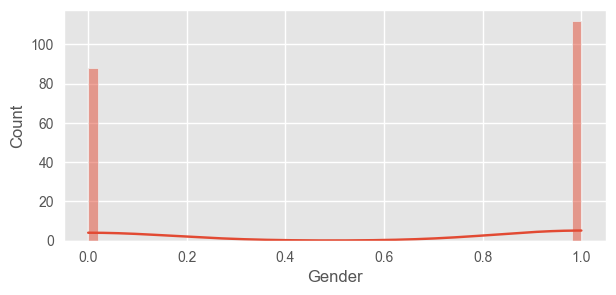

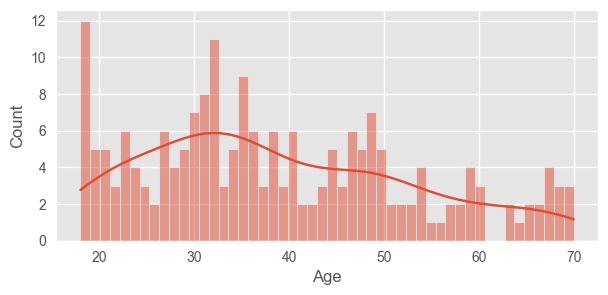

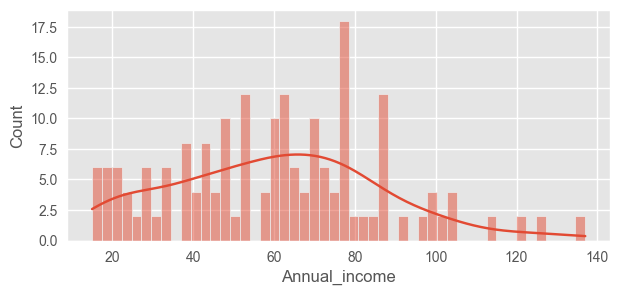

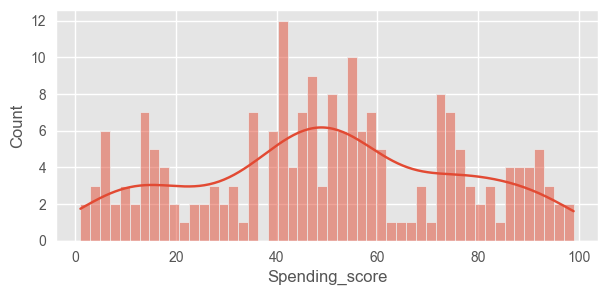

In [13]:
# visualizing the dist of columns
for column in df:
        plt.figure(figsize=(7,3))
        sns.histplot(df[column], bins=50, kde=True);

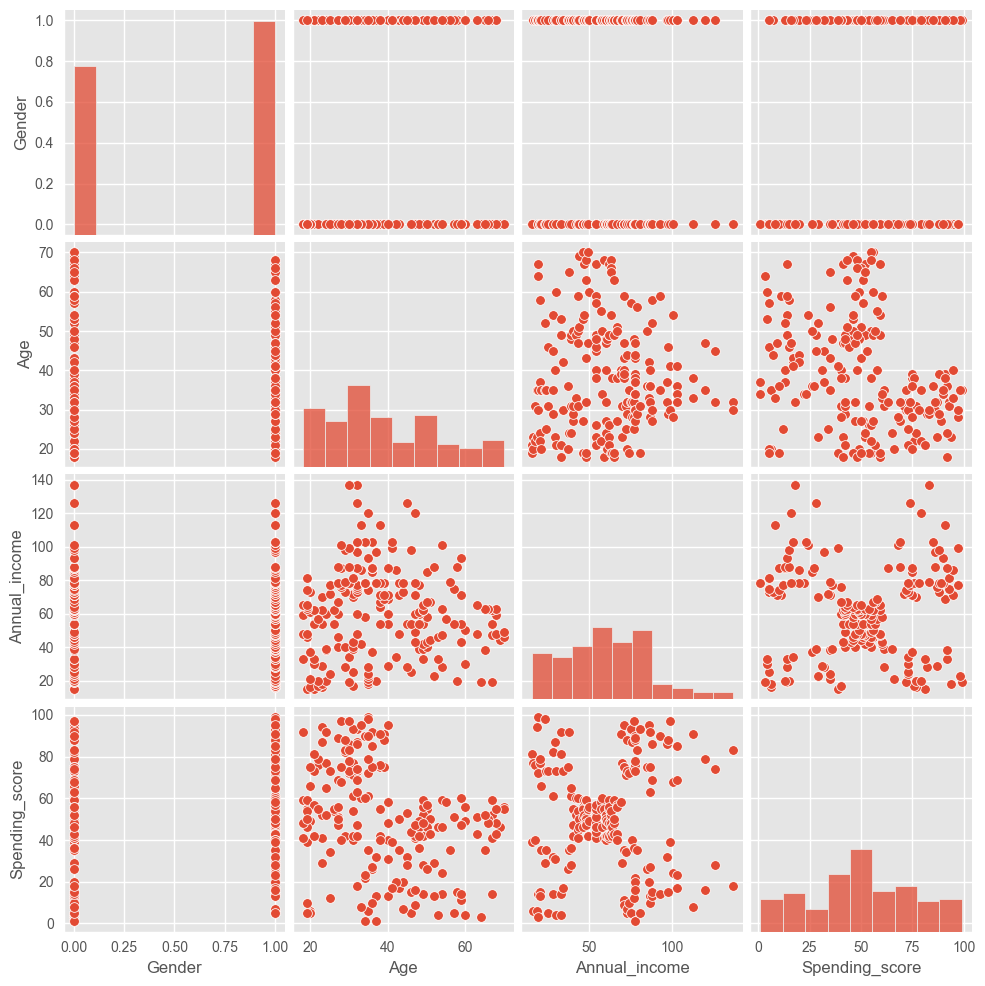

In [14]:
sns.pairplot(df);

the annual income and spending score suggest a pattern in the data

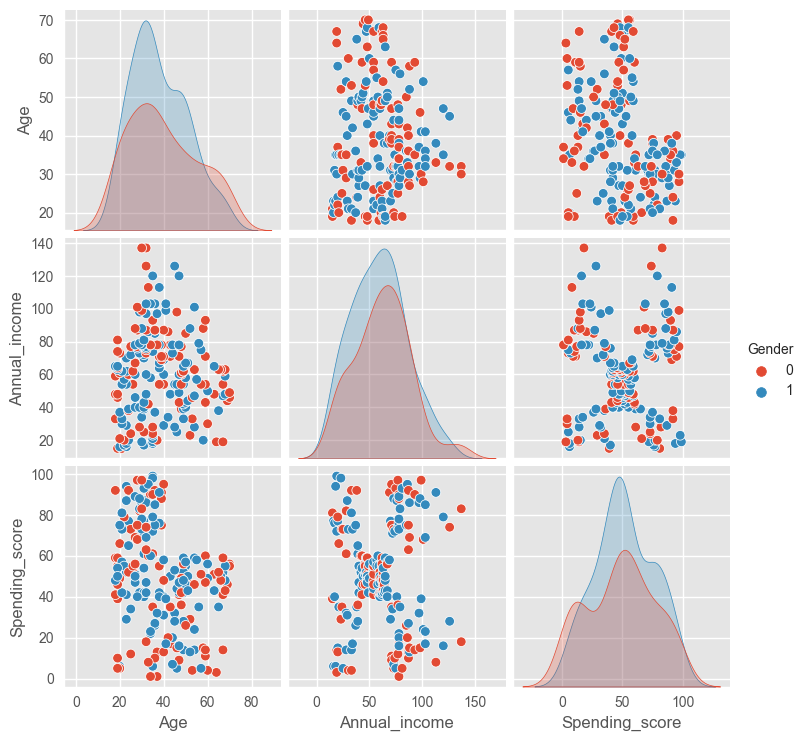

In [15]:
sns.pairplot(df, hue='Gender');

There is no crystal clear conclusion from this data

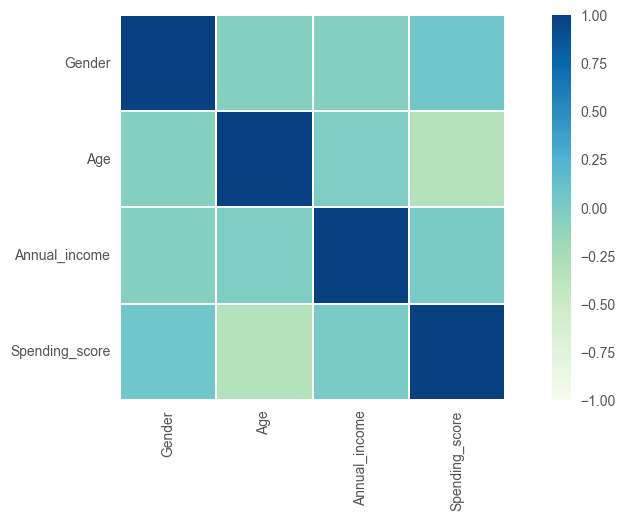

In [16]:
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'GnBu',
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

The features doesn't show any high correlation scores

### Checking outliers

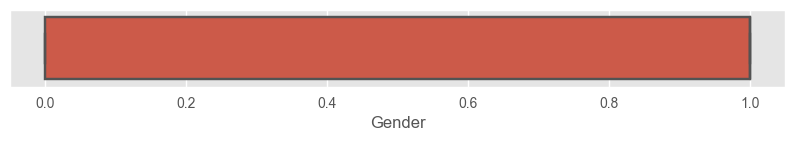

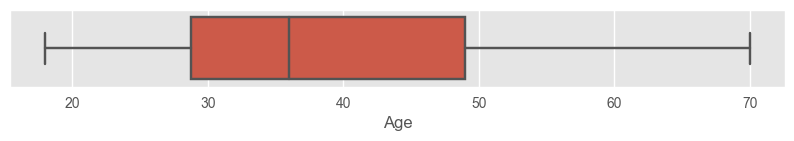

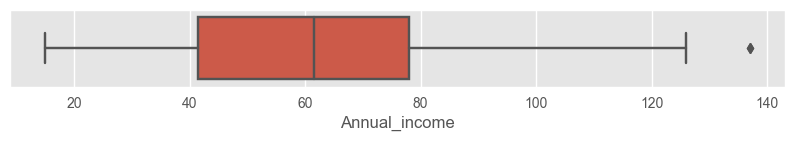

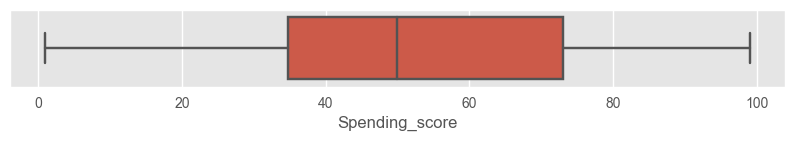

In [17]:
# Outliers check
for column in df:
        plt.figure(figsize=(10,1))
        sns.boxplot(data=df, x=column)

we have some outliers in annual income. K-means is senstive to outliers so we need to check the values and decide. 

In [18]:
# outliers detection through interquartile range
def find_outliers(df_in, col):
    Q1, Q3 = df_in[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    fence_low = Q1 - 1.5 * IQR
    fence_high = Q3 + 1.5 * IQR
    return df_in[(df_in[col] < fence_low) | (df_in[col] > fence_high)].index.tolist()

outliers_indexes = []
for col in df.columns:
    outlier_indexes = find_outliers(df, col)
    outliers_indexes.extend(outlier_indexes)

In [19]:
outliers_indexes

[198, 199]

In [20]:
df.iloc[outliers_indexes]

,Gender,Age,Annual_income,Spending_score
198,0,32,137,18
199,0,30,137,83


The first row show that a customer with high annual income has low spending score. and the second row indecate that another customer with the similar annual income has huge spending score. This may have infleunce over our analysis so we will drop them.

In [21]:
# drop outliers from the dataframe
df.drop(outliers_indexes, inplace=True)

In [22]:
data = df.copy()
data.shape

(198, 4)

---
---

## 3. Cluster Analysis

For the cluster analysis, we will use K-Means [2] and Hierarchical Clustering [3] algorithms. <br>
to determine the best number of clusters we will test diffrent variable and evaluate the best number using elbow method and Silhouette scores. 


### Functions to be used

In [23]:
K = range(2,11) # the range of k for all test

In [24]:
def k_elbow_method(df, K=K):
    """This function calculates the intertia error
      for each number of clusters and return the inertia_ values for all k

    Args:
        df (dataframe): the sub-features
        K (range, optional): The range to pass to be tested. Defaults to K.

    Returns:
        ssd (list): list that stores the intertia error values
    """
    ssd = []
    
    for k in K:
        model = KMeans(n_clusters = k, random_state = 1010)
        model.fit(df)
        ssd.append(model.inertia_) #intertia error
    return ssd

In [25]:
def distortion_k_elbow_method(df, K=K):
    """This function calculates the distance to determine the distortion values  for all k

    Args:
       df (dataframe): the sub-features
       K (range, optional): The range to pass to be tested. Defaults to K.

    Returns:
        distortion (list): list that stores the distortion values
    """
    distortion = [] # distortion values for each k
    for k in K:
        kmeanModel = KMeans(n_clusters = k, random_state = 1010)
        kmeanModel.fit(df)
        distances = kmeanModel.transform(df)
        labels = kmeanModel.labels_
        result = []
        for i in range(k):
            cluster_distances = distances[labels == i, i] 
            result.append(np.mean(cluster_distances ** 2)) 
        distortion.append(sum(result))
    return distortion

In [26]:
def silhouette_k_clusters(df, K=K):
    """This function calculate `silhouette_score` for each k and display the results in a plot

    Args:
       df (dataframe): the sub-features
       K (range, optional): The range to pass to be tested. Defaults to K.
    
    Returns:
        NOTHING
    """
    scores = []
    for n in K:
        kmeans = KMeans(n_clusters = n, random_state = 1010)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg = silhouette_score(df, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(K, scores, 'bo--')
    plt.xlabel('k values')
    plt.ylabel('silhouette score')
    plt.title('k values based on silhouette scores');

In [27]:
def visualize_Kmeans_clusters(model, df):
    """This function fit and visualize the clusters of a k-means model

    Args:
        model:  K-means model 
        df (dataframe): X or the data to be fitted
    
    Returns:
        NOTHING
    """
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(df)    
    visualizer.show(); 

In [28]:
def agglomerativ_silhouette_score(df):
    """This function calculate `silhouette_score` for each k based on
    (Agglomerative Clustering) and display the results in a plot

    Args:
        df (dataframe):  the sub-features

    Returns:
        NOTHING
    """
    scores = []
    for k in K:
        model = AgglomerativeClustering(n_clusters = k)
        model.fit(df)
        cluster_labels = model.labels_
        silhouette_avg = silhouette_score(df, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(K, scores, 'bo--')
    plt.xlabel('k values')
    plt.ylabel('silhouette score')
    plt.title('Silhouette Scores for Agglomerative Clustering');

### Clustering based on Age and Spending Score

In [29]:
X1 = data[['Age', 'Spending_score']].copy()

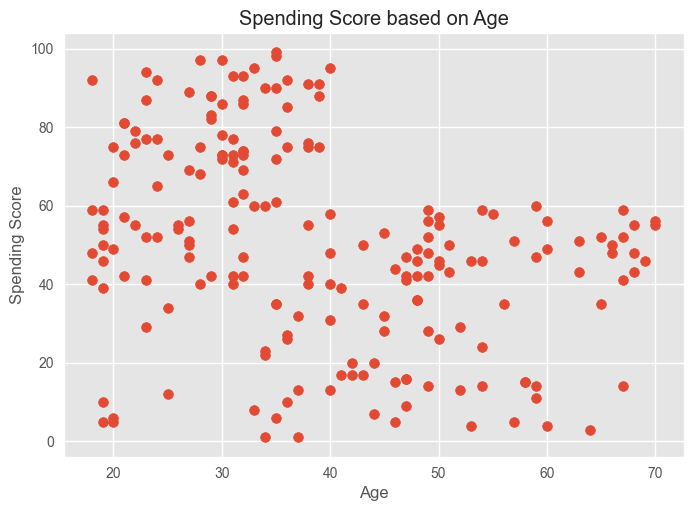

In [30]:
# data before clustering
plt.scatter(X1['Age'], X1['Spending_score'])
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Spending Score based on Age')
plt.show()

#### *ii. Finding the optimal number of clusters*

## Elbow method

In [31]:
ssd = k_elbow_method(X1)

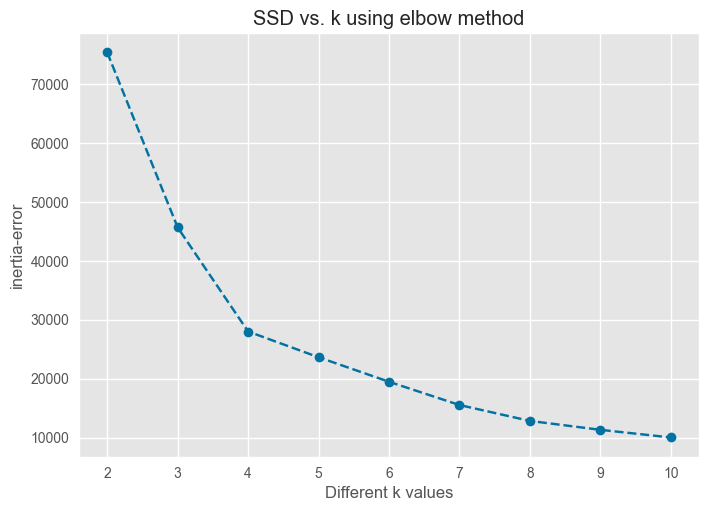

In [32]:
plt.plot(K, ssd, 'bo--')
plt.xlabel('Different k values')
plt.ylabel('inertia-error')
plt.title('SSD vs. k using elbow method');

In [33]:
# print the inertia-error values
-pd.Series(ssd).diff()

0             NaN
1    29732.577854
2    17674.680361
3     4375.250521
4     4165.286710
5     3947.136765
6     2705.050296
7     1510.274685
8     1300.590622
dtype: float64

The elbow method suggests that the optimal number of clusters is 4 

### 

#### analyze the trade-off between the number of clusters and the distortion

In [34]:
distortion = distortion_k_elbow_method(X1)

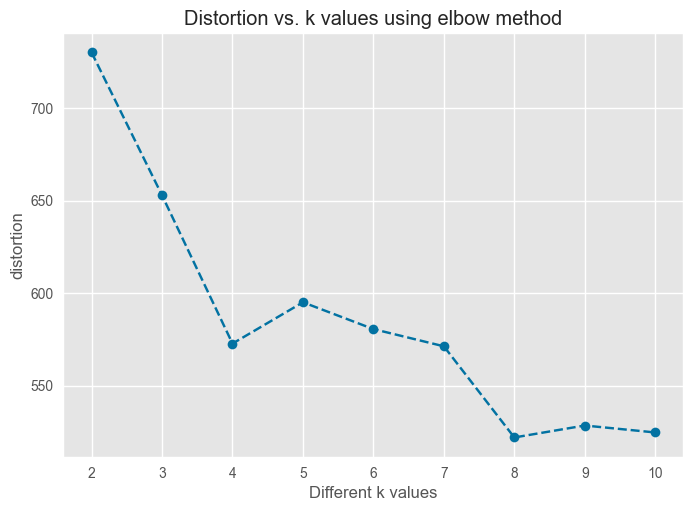

In [35]:
plt.plot(K, distortion, 'bo--')
plt.xlabel('Different k values')
plt.ylabel('distortion')
plt.title('Distortion vs. k values using elbow method');

Both elbow tests have k = 4 as the optimal k number for clustering.

It's important to note that the selection of the optimal number of clusters using the elbow method is subjective and relies on visual plots so it's important to check using Silhouette scores.

### Finding Silhouette Scores for Each Cluster

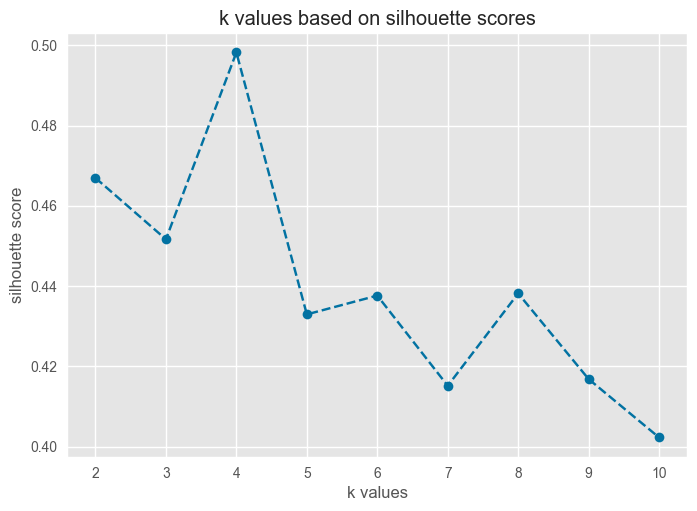

In [36]:
silhouette_k_clusters(X1)

The highest score is the best number. <br>
The silhouette score also suggest 4 as the best number of clusters based on `Age` and `Spending_score`

### What silhouette_score tells us?

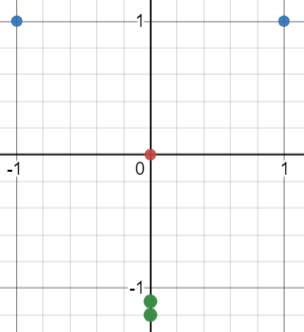

A score close to 1 suggests that the samples are well-clustered and separated from other clusters. A score close to 0 shows overlapping or ambiguous clusters, and negative scores indicate that the samples may have been assigned to incorrect clusters.
<br><br>
Negative silhouette scores can occur when there is significant overlap between clusters or when the k-means algorithm fails to identify distinct clusters in the data. In such cases, it is a sign that the clustering is not meaningful or that the data may not be suitable for clustering.
<br><br>
In our case, the score is around 0.50 for these two features. 

#### *iii. Applying K-Means*

In [37]:
K_means_model1 = KMeans(n_clusters = 4, random_state = 1010) # passing the best k number

In [38]:
K_means_model1.fit(X1)

KMeans(n_clusters=4, random_state=1010)

In [39]:
K_means_model1.labels_

array([0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 0, 1, 3, 0, 3,
       1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 2, 0,
       1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 3, 0, 3, 2, 3, 1, 3, 1, 3,
       0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 1, 3,
       1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3])

#### *iv. Visualizing and Labeling All the Clusters*

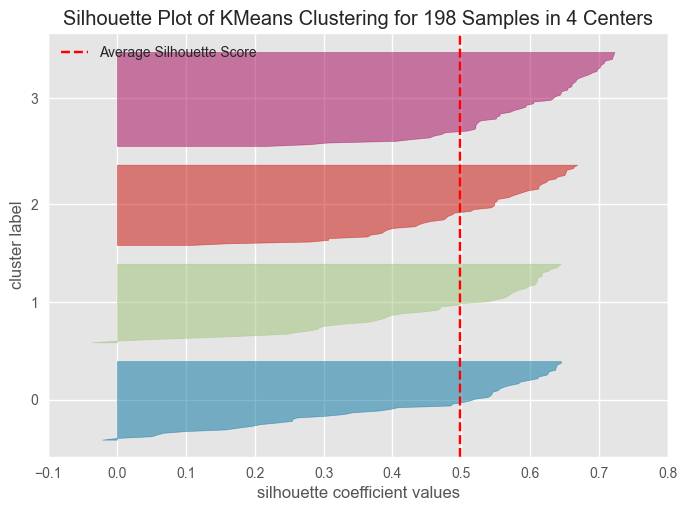

In [40]:
visualize_Kmeans_clusters(K_means_model1, X1)

In [41]:
age_spendingScore_X1 = X1.copy()

In [42]:
age_spendingScore_X1['label'] = K_means_model1.fit_predict(X1) # create new columns to label the data

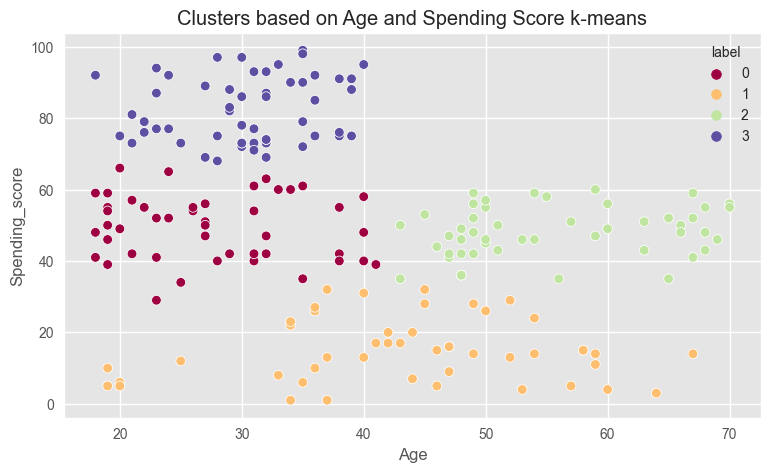

In [43]:
plt.figure(figsize = (9,5))
sns.scatterplot(data = age_spendingScore_X1,
                x = 'Age', 
                y='Spending_score',
                hue='label',
                palette='Spectral')
plt.title('Clusters based on Age and Spending Score k-means')
plt.show();

The k-means model has identified 4 clusters for the age and spending score 

### Clustering based on Annual Income and Spending Score

In [44]:
X2 = data[['Annual_income', 'Spending_score']].copy() # creating new df

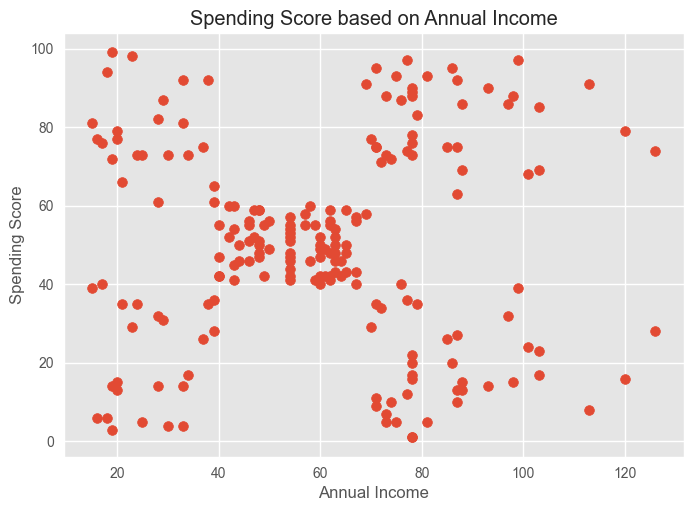

In [45]:
# data before clustering
plt.scatter(X2['Annual_income'], X2['Spending_score'])
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Spending Score based on Annual Income')
plt.show();

#### *ii. Determine optimal number of clusters*

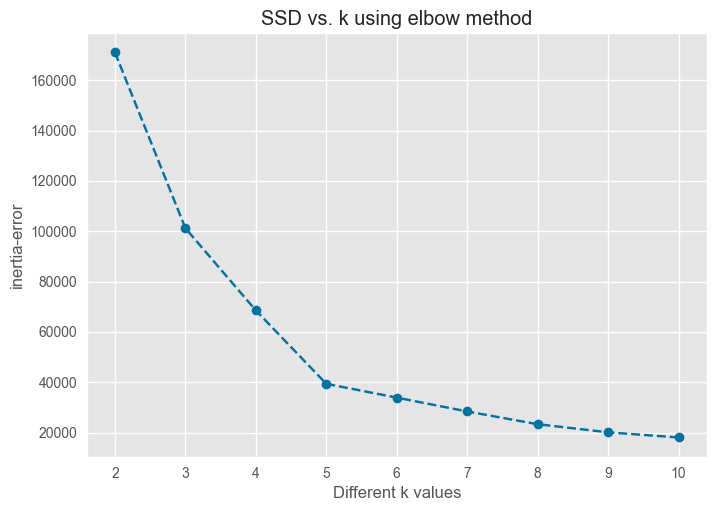

In [46]:
# elbow method
ssd = k_elbow_method(X2)

plt.plot(K, ssd, 'bo--')
plt.xlabel('Different k values')
plt.ylabel('inertia-error')
plt.title('SSD vs. k using elbow method');

k = 5 is the optimal number

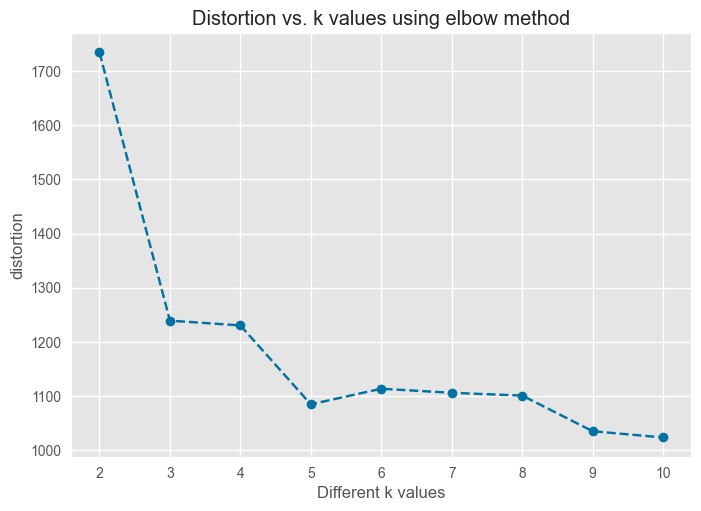

In [48]:
distortion = distortion_k_elbow_method(X2)

plt.plot(K, distortion, 'bo--')
plt.xlabel('Different k values')
plt.ylabel('distortion')
plt.title('Distortion vs. k values using elbow method');

the 2nd test also confirm it at k = 5

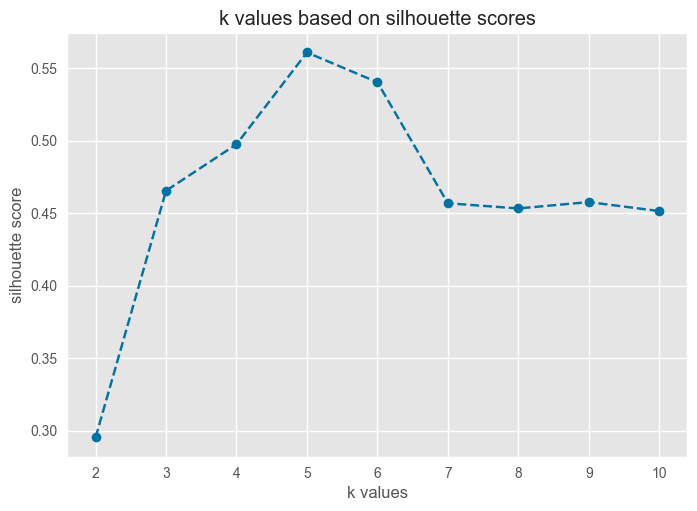

In [49]:
# using silhouette scores
silhouette_k_clusters(X2)

silhouette scores are higher at k = 5. So 5 will be our choice.

#### *iii. Apply K Means*

In [50]:
K_means_model2 = KMeans(n_clusters = 5, random_state = 1010) # passing the best k number

In [51]:
K_means_model2.fit(X2)

KMeans(n_clusters=5, random_state=1010)

#### *iv. Visualizing and Labeling All the Clusters*

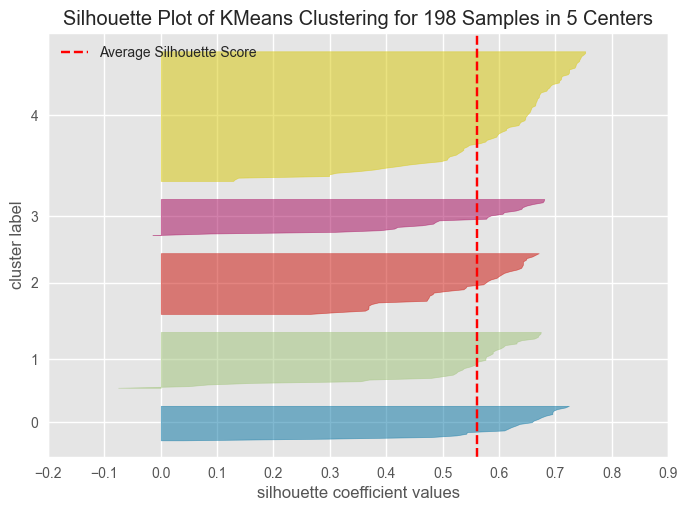

In [52]:
visualize_Kmeans_clusters(K_means_model2, X2)

In [53]:
age_annualIncome_X2 = X2.copy()

In [54]:
age_annualIncome_X2['label'] = K_means_model2.fit_predict(X2) # create new columns to label the data

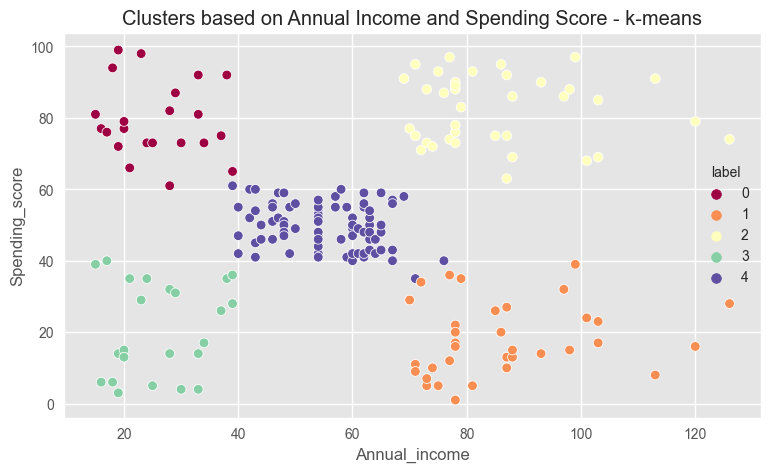

In [55]:
plt.figure(figsize = (9,5))
sns.scatterplot(data = age_annualIncome_X2,
                x = 'Annual_income', 
                y ='Spending_score',
                hue ='label',
                palette='Spectral')
plt.title('Clusters based on Annual Income and Spending Score - k-means')
plt.show();

We have 5 clusters identified by the K-means for annual income and spending scores

### Hierarchical Clustering

In this section we will do hierarchical clustering which involve merging or splitting clusters based on their similarity. It does not require a predefined number of clusters, and it provides a visual representation of the clustering structure in the form of a dendrogram.

### *i. Determine optimal number of clusters using Dendogram*

### Clustering based on Age and Spending Score- x1

In [56]:
# linkage methods
hc_ward = linkage(X1, method='ward')
hc_complete = linkage(X1, 'complete')
hc_average = linkage(X1, 'average')
hc_single = linkage(X1, 'single')

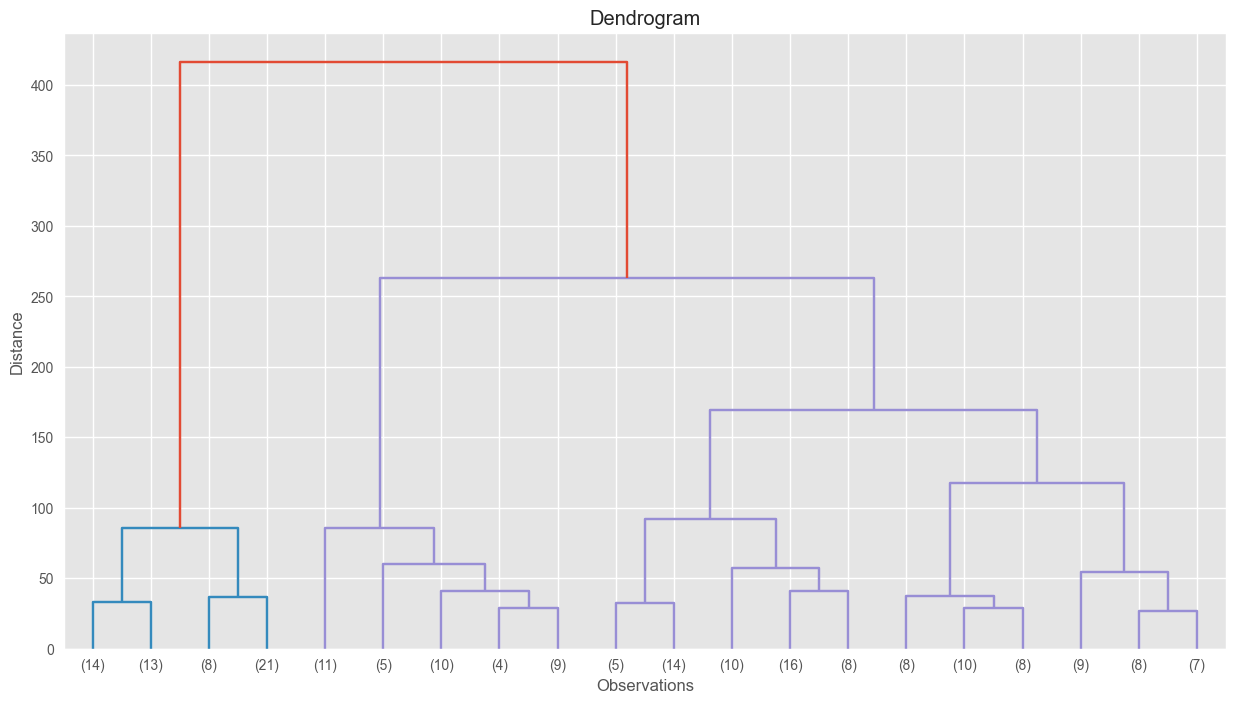

In [57]:
plt.figure(figsize = (15,8))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hc_ward, leaf_font_size=10, truncate_mode='lastp', p=20);

The best number of clusters based on this dendogram is 4

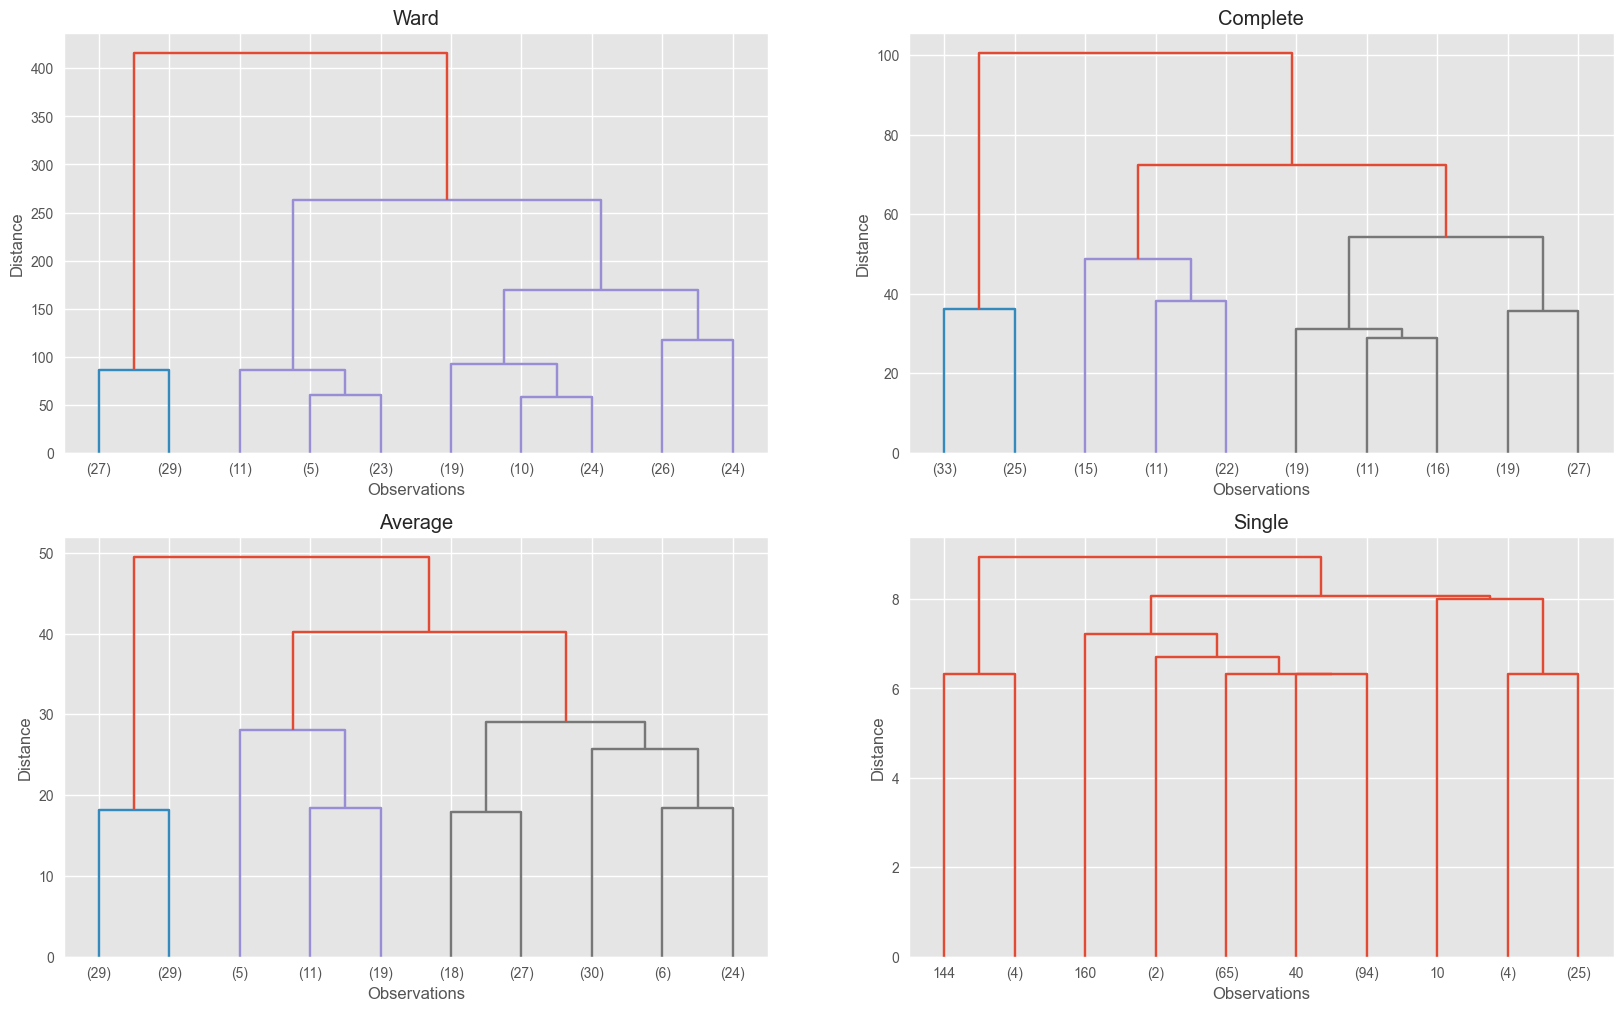

In [58]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp', p = 10);

with diffirent linkage method the optimal cluster number is around 4

## Clustering based on Annual Income and Spending Score- x2

In [59]:
# linkage methods
hc_ward = linkage(X2, method='ward')
hc_complete = linkage(X2, 'complete')
hc_average = linkage(X2, 'average')
hc_single = linkage(X2, 'single')

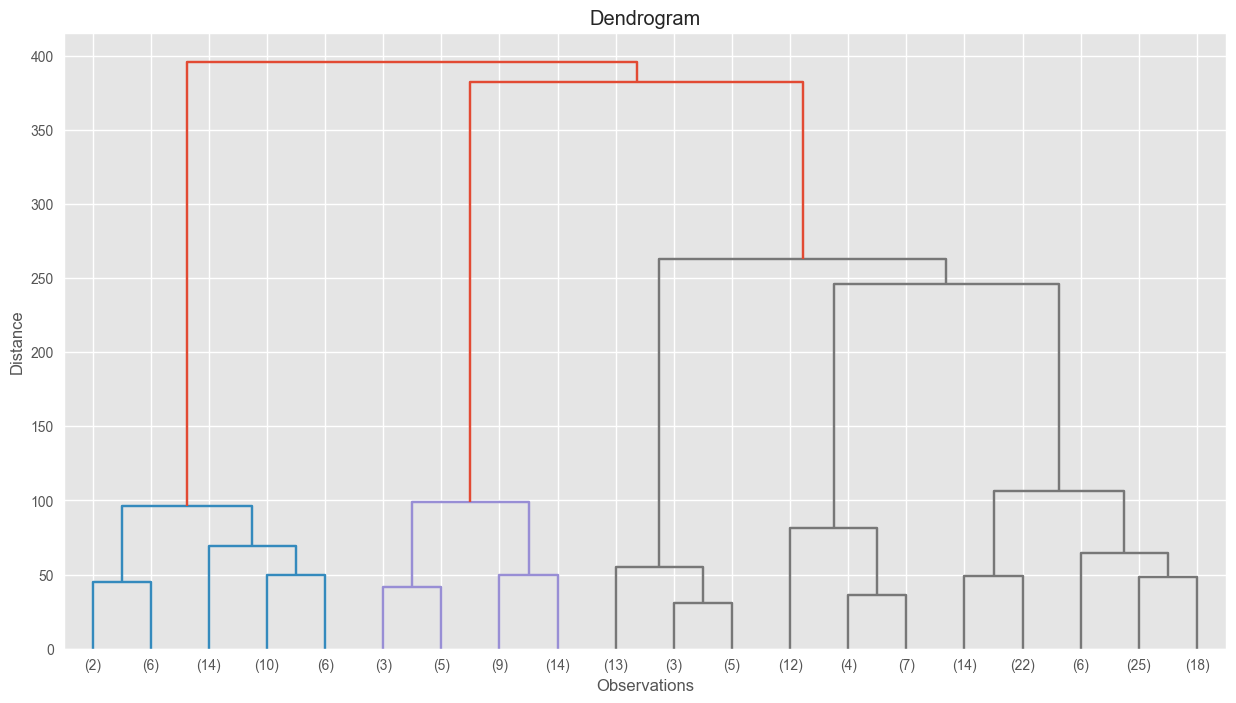

In [60]:
plt.figure(figsize = (15,8))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hc_ward, leaf_font_size=10, truncate_mode='lastp', p=20);

based on the dendogram, the best number of clusters for X2 is 5

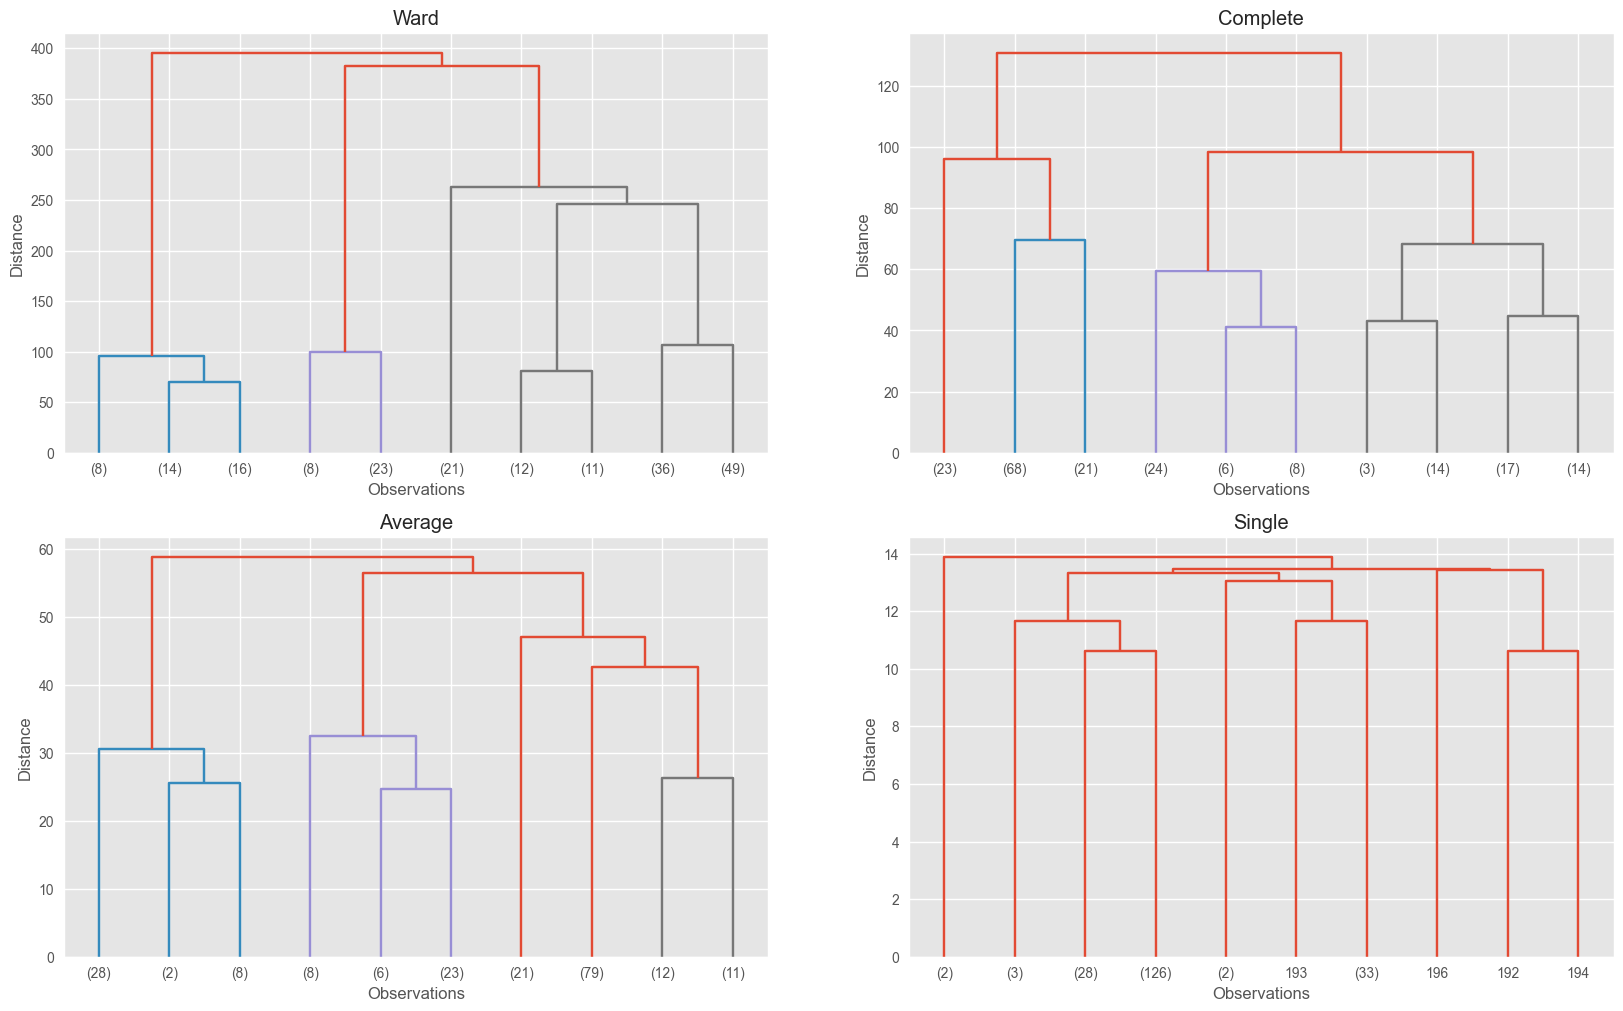

In [61]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p = 10);

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp', p = 10);

Each linkage suggest a diffirent number of clusters

### ii. *Apply Agglomerative Clustering*

#### Age and Spending Score- x1

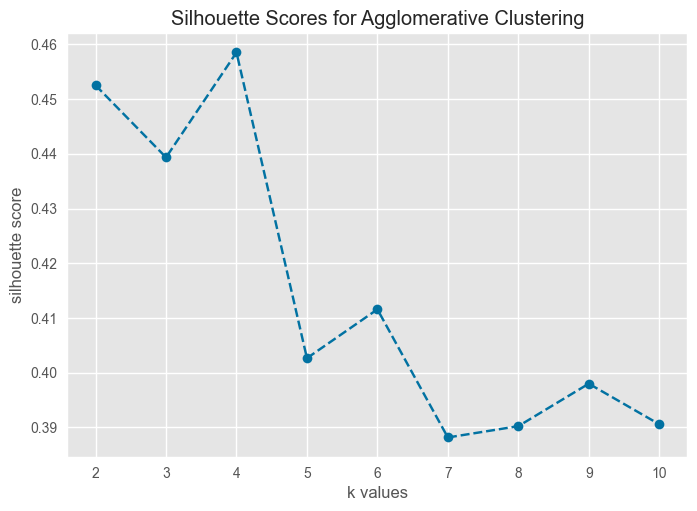

In [62]:
# checking using silhouette score
agglomerativ_silhouette_score(X1)

4 as the best k value

In [63]:
agg_clustering_X1 = AgglomerativeClustering(n_clusters = 4, 
                                            metric = 'euclidean',
                                            linkage = 'ward')

In [64]:
agg_clustering_X1.fit(X1)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [65]:
agg_X1 = X1.copy()

In [66]:
agg_X1['label'] = agg_clustering_X1.fit_predict(X1) 

#### Annual Income and Spending Score- x2

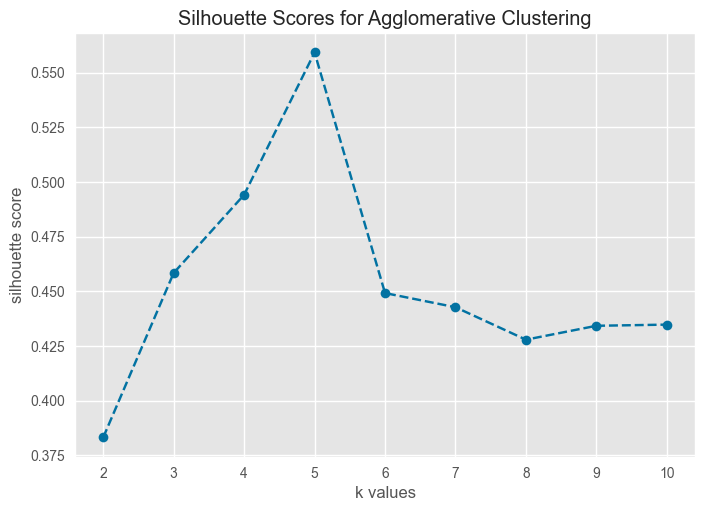

In [67]:
agglomerativ_silhouette_score(X2)

5 as best number of clusters

In [68]:
agg_clustering_X2 = AgglomerativeClustering(n_clusters = 5, 
                                            metric = 'euclidean',
                                            linkage = 'ward')

In [69]:
agg_clustering_X2.fit(X2)

AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [70]:
agg_X2 = X2.copy()

In [71]:
agg_X2['label'] = agg_clustering_X2.fit_predict(X2) 

### iii. *Visualizing the Clusters* 

#### Age and Spending Score- x1

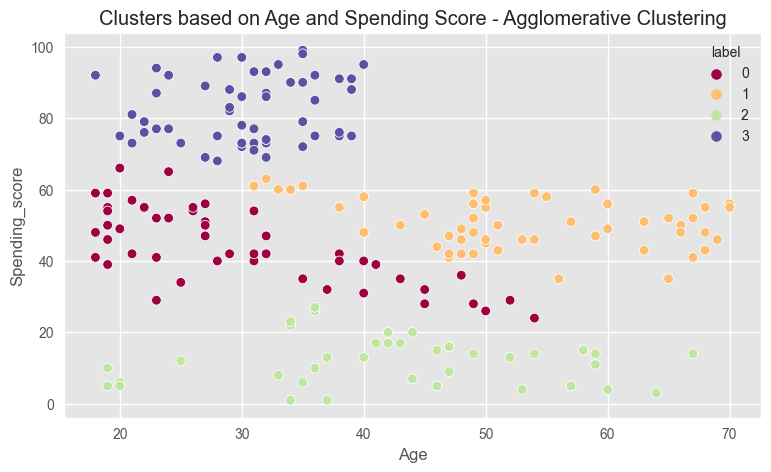

In [72]:
plt.figure(figsize = (9,5))
sns.scatterplot(data = agg_X1,
                x = 'Age', 
                y='Spending_score',
                hue='label',
                palette='Spectral')
plt.title('Clusters based on Age and Spending Score - Agglomerative Clustering')
plt.show();

#### Annual Income and Spending Score- x2

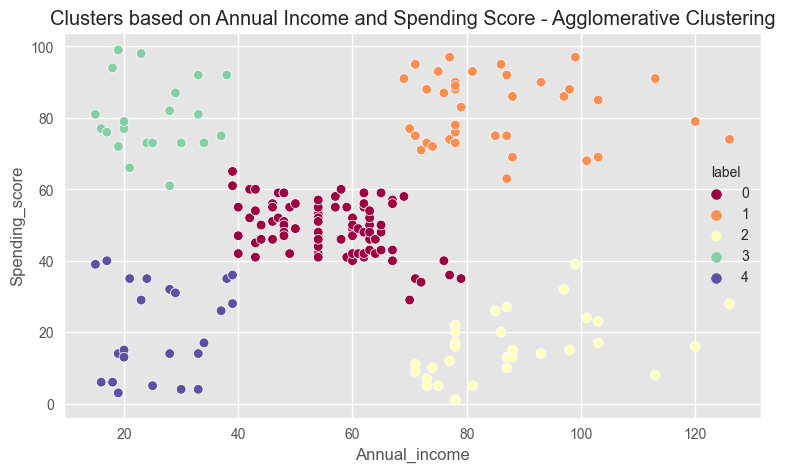

In [73]:
plt.figure(figsize = (9,5))
sns.scatterplot(data = agg_X2,
                x = 'Annual_income', 
                y ='Spending_score',
                hue ='label',
                palette='Spectral')
plt.title('Clusters based on Annual Income and Spending Score - Agglomerative Clustering')
plt.show();

#### Interpretation based on Age and Spending Score- x1

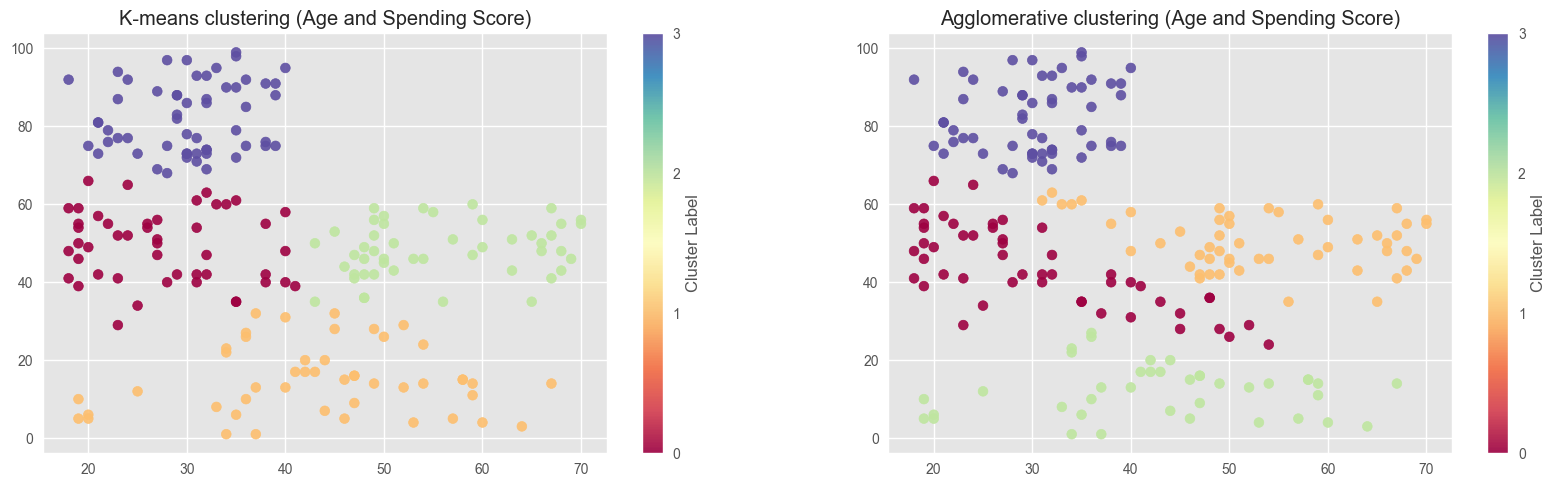

In [74]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.scatter(X1["Age"],
            X1["Spending_score"],
            c=K_means_model1.labels_,
            cmap='Spectral',
            alpha=0.9)
plt.title('K-means clustering (Age and Spending Score)')
plt.colorbar(ticks=range(K_means_model1.n_clusters), label='Cluster Label')

plt.subplot(222)
plt.scatter(X1["Age"],
            X1["Spending_score"],
            c=agg_clustering_X1.labels_,
            cmap='Spectral',
            alpha=0.9)
plt.title('Agglomerative clustering (Age and Spending Score)')
plt.colorbar(ticks=range(agg_clustering_X1.n_clusters), label='Cluster Label');

diffirent distributions for the clusters between Agglomerative and k-means

In [75]:
# calculate silhouette_score for both models
labels = K_means_model1.labels_
silhouette_score(X1, labels).round(4)

0.4982

In [76]:
labels2 = agg_clustering_X1.labels_
silhouette_score(X1, labels2).round(4)

0.4585

For the final analysis we will only use k-means clusters since it has higher score

In [77]:
age_spendingScore_X1.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,198.0,38.929293,14.016852,18.0,28.25,36.0,49.00,70.0
Spending_score,198.0,50.196970,25.746846,1.0,35.00,50.0,72.75,99.0
label,198.0,1.570707,1.136631,0.0,1.00,2.0,3.00,3.0


In [78]:
clusters_mean_age = age_spendingScore_X1.groupby(['label']).mean()['Age'].sort_values()
clusters_mean_age

label
0    27.617021
3    30.178571
1    43.531915
2    55.708333
Name: Age, dtype: float64

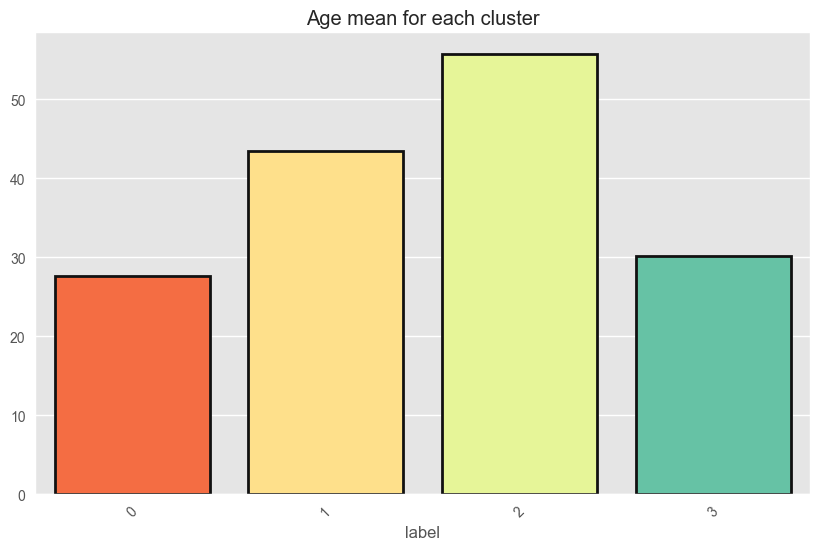

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(x = clusters_mean_age.index, y = clusters_mean_age.values, saturation=1, edgecolor='k',
            linewidth=2, palette='Spectral')
plt.xticks(rotation=45)
plt.title('Age mean for each cluster')
plt.show()

In [80]:
df_with_labels = pd.concat([data, age_spendingScore_X1['label']], axis=1)
df_with_labels.head(3)

,Gender,Age,Annual_income,Spending_score,label
0,0,19,15,39,0
1,0,21,15,81,3
2,1,20,16,6,1


calculate the mean scores for each column

In [81]:
clusters_mean_income = df_with_labels.groupby(['label']).mean()['Annual_income'].sort_values()
clusters_mean_income

label
0    53.276596
2    54.770833
3    64.803571
1    65.446809
Name: Annual_income, dtype: float64

In [82]:
clusters_mean_score = df_with_labels.groupby(['label']).mean()['Spending_score'].sort_values()
clusters_mean_score

label
1    14.957447
2    48.229167
0    49.148936
3    82.339286
Name: Spending_score, dtype: float64

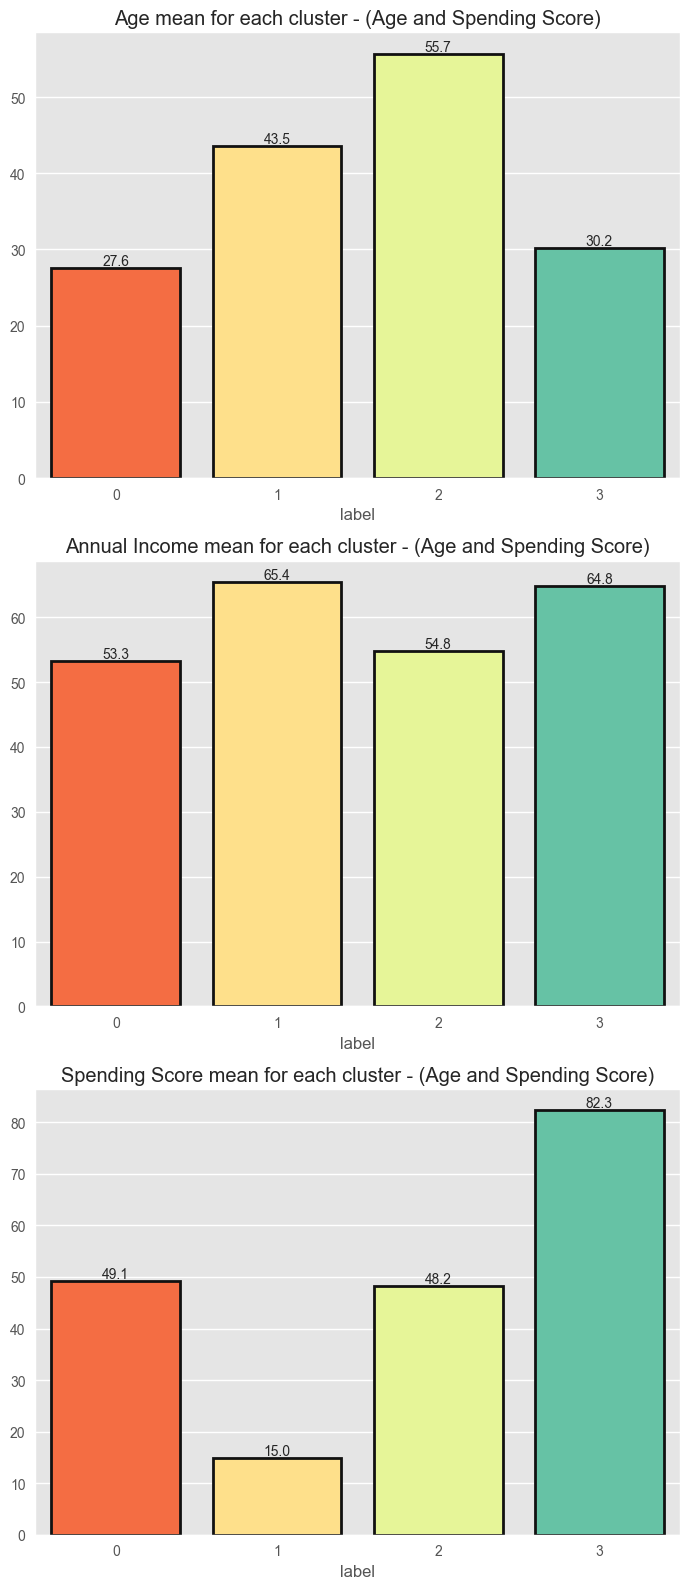

In [83]:
plt.figure(figsize=(7, 16))

plt.subplot(311)
ax = sns.barplot(x = clusters_mean_age.index, y = clusters_mean_age.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Age mean for each cluster - (Age and Spending Score)')

plt.subplot(312)
ax = sns.barplot(x=clusters_mean_income.index, y=clusters_mean_income.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Annual Income mean for each cluster - (Age and Spending Score)')

plt.subplot(313)
ax = sns.barplot(x=clusters_mean_score.index, y=clusters_mean_score.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Spending Score mean for each cluster - (Age and Spending Score)')

plt.tight_layout()
plt.show();

### Conclusion

**cluster 0** : The average `Age` is around 28, both `Annual_income` and `Spending_scores` have an average around 50. 
more research can be conducted regarding this cluster.

**cluster 1**: The average age is around 44, the `Annual_income` is high but the `Spending_scores` are very low. 
This can be a possible target group to increase the spending score through marketing stratigies. 

**cluster 2** : The average age is around 55. The `Annual_income` and `Spending_scores` are on average. 
more research can be conducted regarding this cluster to increase thier scores.
 
    
**cluster 3**: The average age is around 30. The `Annual_income` and `Spending_scores` are both high. 
We can label this cluster as loyal customers since they spend more than other groups and we can make special offers for them.  

### Conclusion

Analysis for (Age and Spending Score) based on gender: 


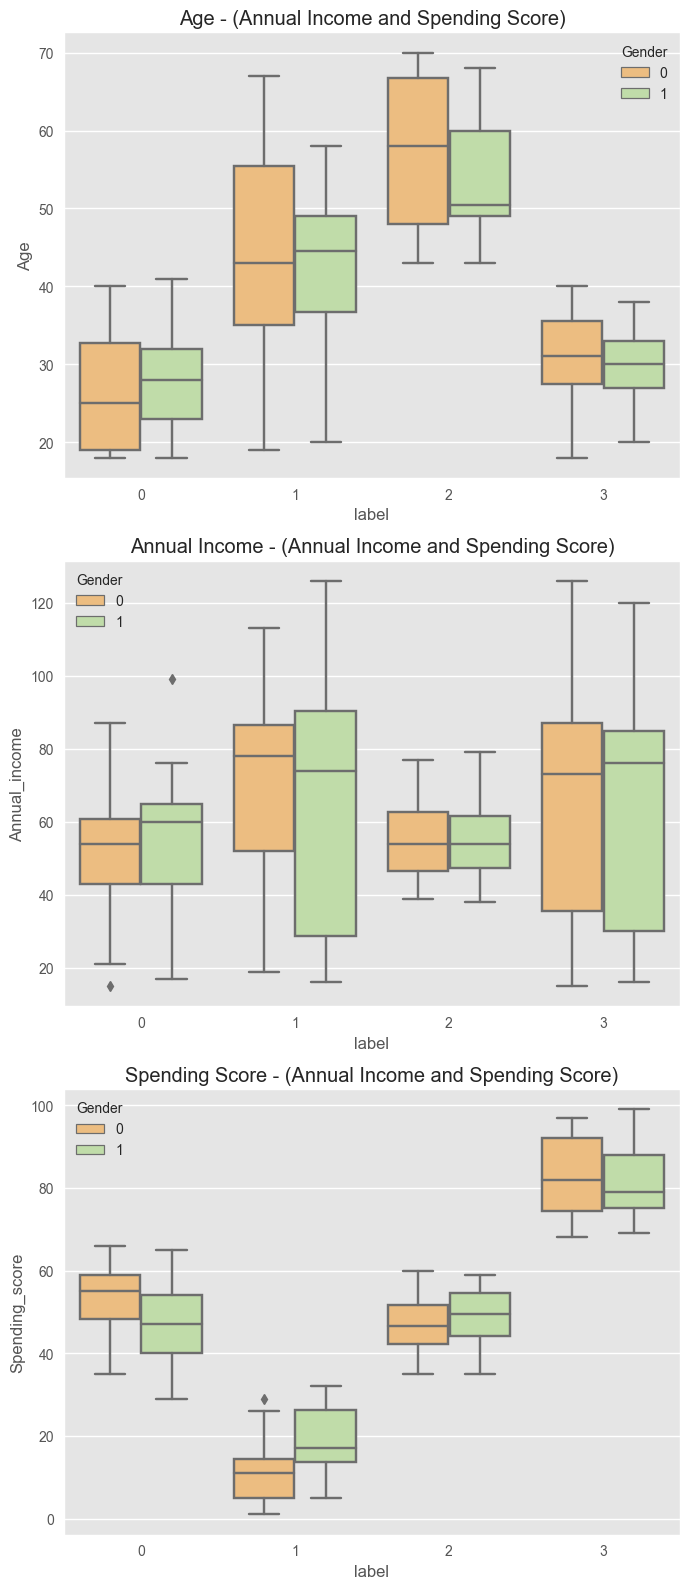

In [84]:
plt.figure(figsize=(7, 16))

plt.subplot(311)
ax = sns.boxplot(data = df_with_labels, y='Age', x='label', hue='Gender',palette='Spectral')
plt.title('Age - (Annual Income and Spending Score)')

plt.subplot(312)
ax = sns.boxplot(data = df_with_labels, y='Annual_income', x='label', hue='Gender', palette='Spectral')
plt.title('Annual Income - (Annual Income and Spending Score)')

plt.subplot(313)
sns.boxplot(data = df_with_labels, y='Spending_score', x='label', hue='Gender', palette='Spectral')
plt.title('Spending Score - (Annual Income and Spending Score)')

plt.tight_layout()
plt.show();

### Female

**cluster 0** : The average age is around 28, both `Annual_income` and `Spending_scores` are on average. 
It should be researched what can be done to direct more spending.

**cluster 1**: The average age is around 45, and `Spending_scores` are very low for this cluster.
more research is required to increase spending score. 


**cluster 2** :The average age is around 50. both `Annual_income` and `Spending_scores` are on average. They may not bring much profit.

**cluster 3**: The average age is around 30. average  `Annual_income` but very high spending scores.
This group consists of loyal customers, very special promotions can be made in order not to miss it.


### Male

**cluster 0** : The average age is around 25, both `Annual_income` and `Spending_scores` are on average. 
It should be researched what can be done to direct more spending.

**cluster 1**: The average age is around 42, `Annual_income` is high but the spending_scores is low.
This group is our target audience and special strategies need to be developed for this group.    

**cluster 2** :The average age is around 59. `Annual_income` and `Spending_scores` are on average. 
They may not bring much profit.

**cluster 3**: The average age is around 30. `Annual_income` and `Spending_scores` are high, these are loyal customers and  very special promotions can be made in order not to miss it.


#### Interpretation based on Annual Income and Spending Score- x2

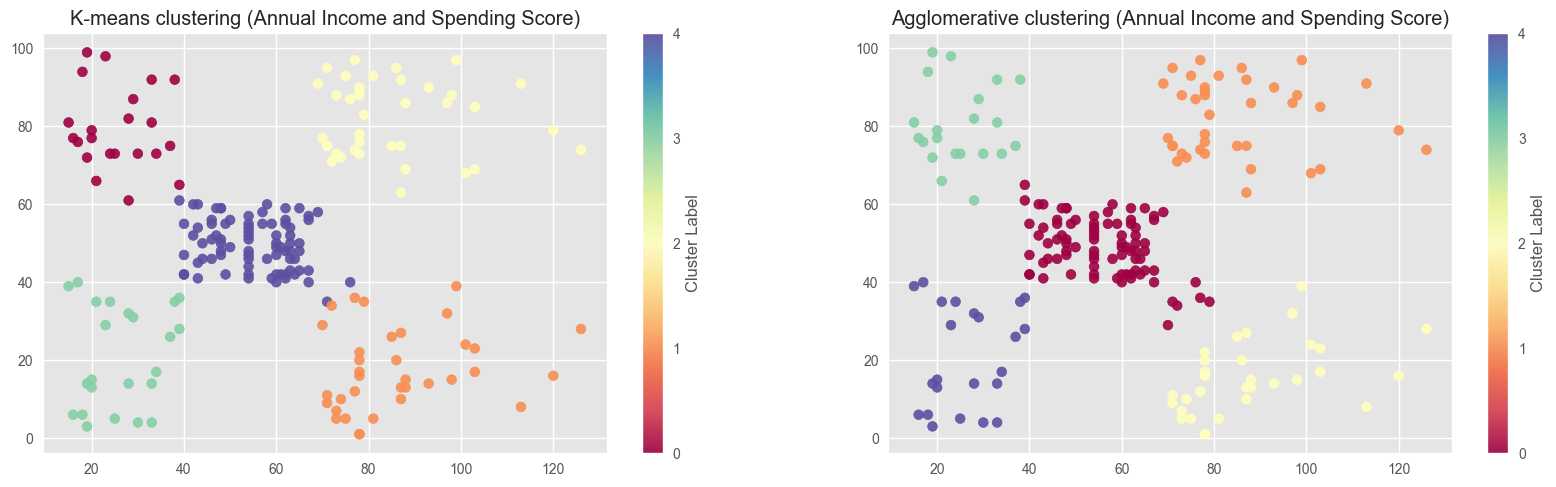

In [85]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.scatter(X2["Annual_income"],
            X2["Spending_score"],
            c=K_means_model2.labels_,
            cmap='Spectral',
            alpha=0.9)
plt.title('K-means clustering (Annual Income and Spending Score)')
plt.colorbar(ticks=range(K_means_model2.n_clusters), label='Cluster Label')

plt.subplot(222)
plt.scatter(X2["Annual_income"],
            X2["Spending_score"],
            c=agg_clustering_X2.labels_,
            cmap='Spectral',
            alpha=0.9)
plt.title('Agglomerative clustering (Annual Income and Spending Score)')
plt.colorbar(ticks=range(agg_clustering_X2.n_clusters), label='Cluster Label');

By analyzing the plots, the middle cluster in this agglomerative clustering has more points compared to the k-means cluster 0

In [86]:
labels = K_means_model2.labels_
silhouette_score(X2, labels).round(4)

0.5607

In [87]:
labels2 = agg_clustering_X2.labels_
silhouette_score(X2, labels2).round(4)

0.5593

with a slight margin the k-means has better score

In [88]:
age_annualIncome_X2.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual_income,198.0,59.787879,25.237259,15.0,40.5,61.0,77.75,126.0
Spending_score,198.0,50.196970,25.746846,1.0,35.0,50.0,72.75,99.0
label,198.0,2.525253,1.445058,0.0,1.0,3.0,4.00,4.0


In [89]:
df_with_labels2 = pd.concat([data, age_annualIncome_X2['label']], axis=1)
df_with_labels2.head(3)

,Gender,Age,Annual_income,Spending_score,label
0,0,19,15,39,3
1,0,21,15,81,0
2,1,20,16,6,3


In [90]:
clusters_mean_income2 = df_with_labels2.groupby(['label']).mean()['Annual_income'].sort_values()
clusters_mean_income2

label
0    25.727273
3    26.304348
4    55.087500
2    85.210526
1    86.342857
Name: Annual_income, dtype: float64

In [91]:
clusters_mean_age2 = df_with_labels2.groupby(['label']).mean()['Age'].sort_values()
clusters_mean_age2

label
0    25.272727
2    32.763158
1    40.914286
4    42.937500
3    45.217391
Name: Age, dtype: float64

In [92]:
clusters_mean_score2 = df_with_labels2.groupby(['label']).mean()['Spending_score'].sort_values()
clusters_mean_score2

label
1    17.571429
3    20.913043
4    49.712500
0    79.363636
2    82.105263
Name: Spending_score, dtype: float64

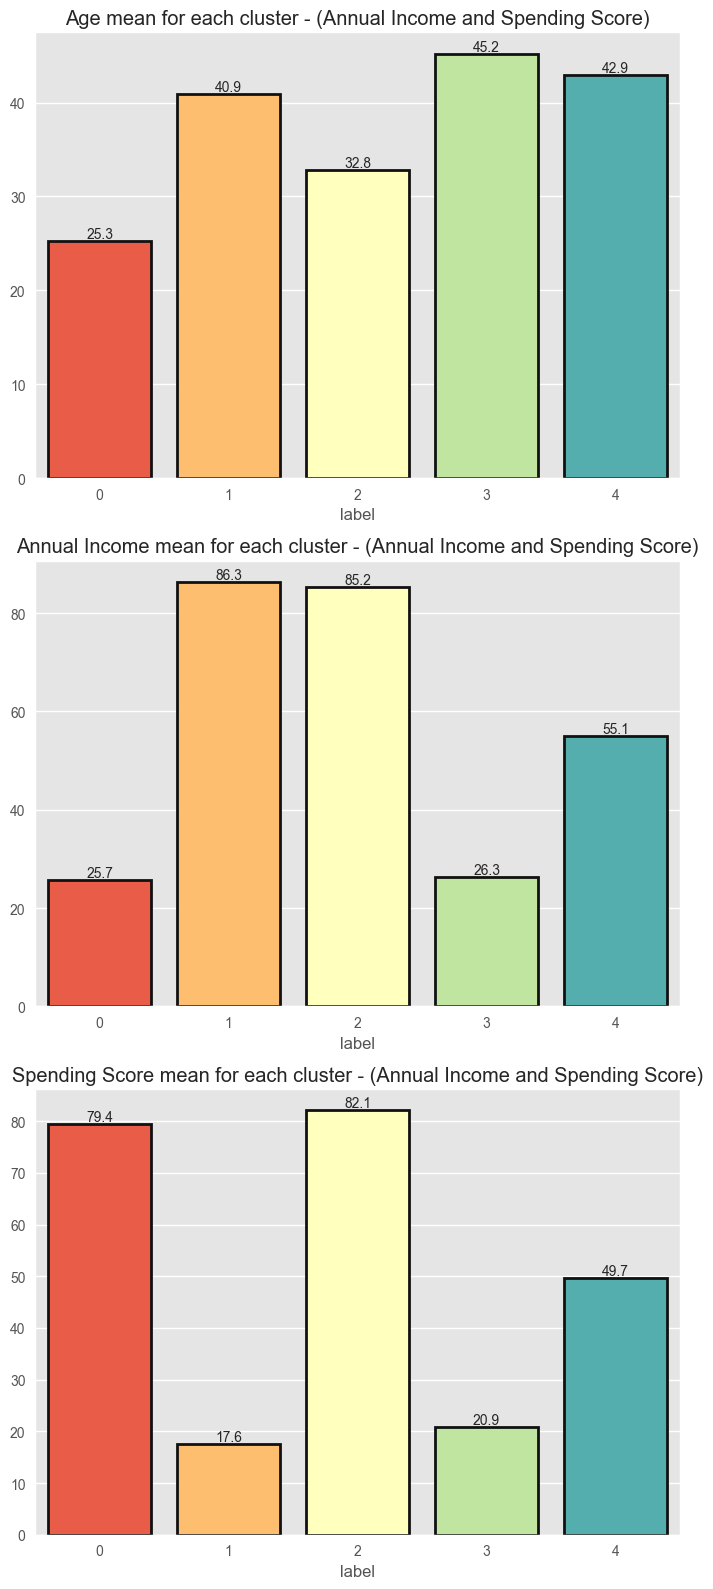

In [93]:
plt.figure(figsize=(7, 16))

plt.subplot(311)
ax = sns.barplot(x = clusters_mean_age2.index, y = clusters_mean_age2.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Age mean for each cluster - (Annual Income and Spending Score)')

plt.subplot(312)
ax = sns.barplot(x=clusters_mean_income2.index, y=clusters_mean_income2.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Annual Income mean for each cluster - (Annual Income and Spending Score)')

plt.subplot(313)
ax = sns.barplot(x=clusters_mean_score2.index, y=clusters_mean_score2.values, 
                 saturation=1, edgecolor='k',linewidth=2,palette='Spectral')
ax.bar_label(ax.containers[0], fmt="%.1f")
plt.title('Spending Score mean for each cluster - (Annual Income and Spending Score)')


plt.tight_layout()
plt.show();

**cluster 0** : The average `Age` is around 25, the `Annual_income` has lower average compared to `Spending_scores`.
we can target this group by providing them with discount copons. 

**cluster 1**: The average age is around 40, the `Annual_income` is high but the `Spending_scores` are low. 
This group can bring much profit, more research is needed for this cluster.

**cluster 2** : The average age is around 30. The `Annual_income` and `Spending_scores` are both very high. 
These are the most loyal customers, should prepare tailored offers for them.
 
    
**cluster 3**: The average age is around 45. The `Annual_income` and `Spending_scores` are both average. 
more research is needed to look for possible improvements.

**cluster 4**: The average age is around 40, their `Annual_income` and `Spending_scores` are moderate.
more stratigies for them can improve thier spending score.

## Conclusion

Analysis for (Annual Income and Spending Score) based on gender: 

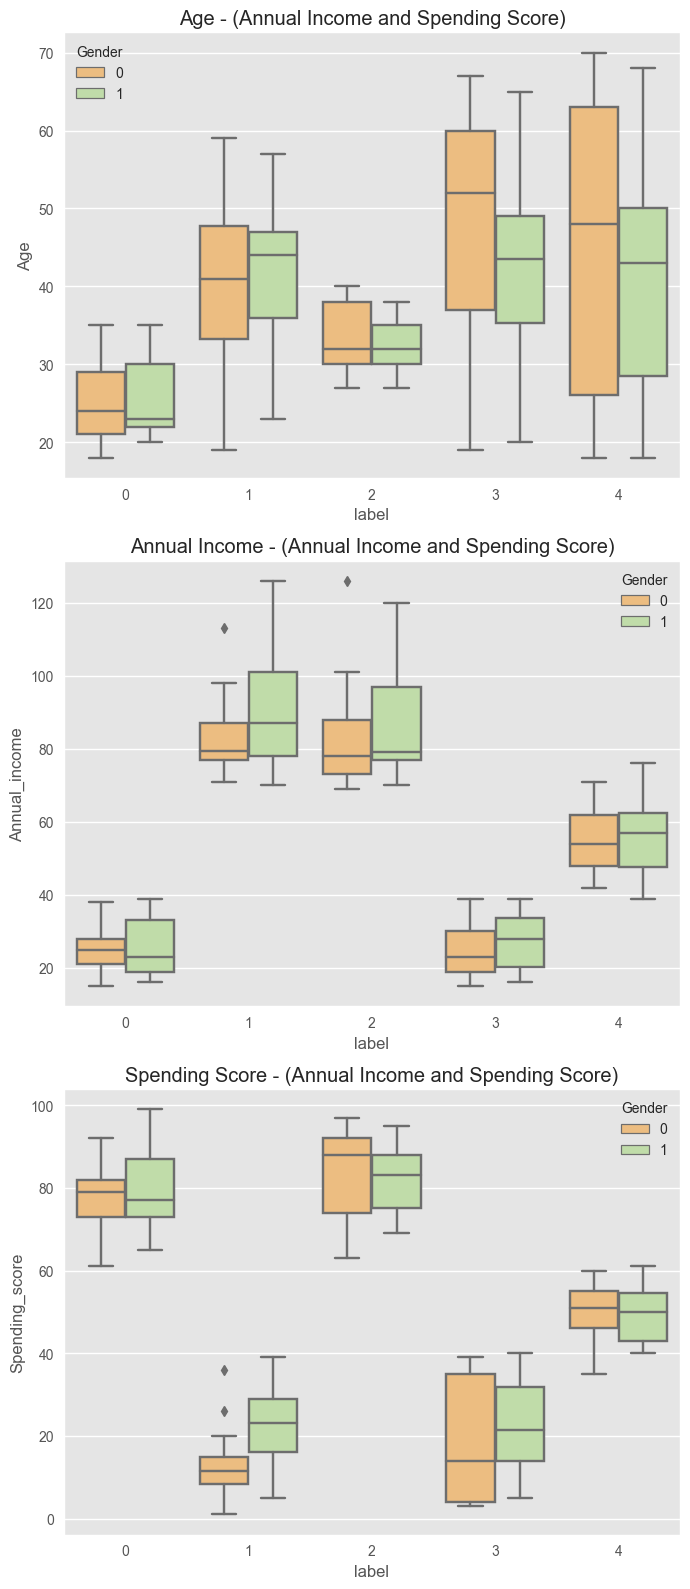

In [94]:
plt.figure(figsize=(7, 16))

plt.subplot(311)
ax = sns.boxplot(data = df_with_labels2, y='Age', x='label', hue='Gender',palette='Spectral')
plt.title('Age - (Annual Income and Spending Score)')

plt.subplot(312)
ax = sns.boxplot(data = df_with_labels2, y='Annual_income', x='label', hue='Gender', palette='Spectral')
plt.title('Annual Income - (Annual Income and Spending Score)')

plt.subplot(313)
sns.boxplot(data = df_with_labels2, y='Spending_score', x='label', hue='Gender', palette='Spectral')
plt.title('Spending Score - (Annual Income and Spending Score)')

plt.tight_layout()
plt.show();

### Female

**cluster 0** : The average age is around 25. Low `Annual_income` but very high  `Spending_scores`. This 
group does a lot of shopping, but they do not bring much profit.


**cluster 1**: The average age is around 40, `Annual_income` is high but `Spending_scores` are low. 
It should be researched what can be done to direct more spending.
   

**cluster 2** : The average age is around 30, the `Annual_income` and the `Spending_scores`
is very high. This group consists of our loyal customers. Our company derives the main profit from this group. 
Very special promotions can be made in order not to miss it.

**cluster 3**: The average age is around 50. Both `Annual_income` and `Spending_scores` are low. It can be 
directed to shopping with gift certificates.

**cluster 4**: The average age is around 47, the `Annual_income` and `Spending_scores` are average.
Not much profit can be made with this group.

### Male

**cluster 0** : The average age is around 25. Low `Annual_income` but very high `Spending_scores`. This 
group does a lot of shopping, but they do not bring much profit.


**cluster 1**: The average age is around 40, the `Annual_income` is very high but the `Spending_scores` is very low.
This group is our target audience and special strategies need to be developed for this group.    

**cluster 2** : The average age is around 30, the `Annual_income` and the `Spending_scores`
is very high. This group consists of our loyal customers. Our company derives the main profit from this group. 
Very special promotions can be made in order not to miss it.

**cluster 3**: The average age is around 50. Both `Annual_income` and `Spending_scores` are low. It can be 
directed to shopping with gift certificates.


**cluster 4**: The average age is around 48, both `Annual_income` and `Spending_scores` are on average. 
It should be researched what can be done to direct more spending.

## References


[1] https://www.kaggle.com/datasets/shwetabh123/mall-customers <br>
[2] https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1 <br>
[3] https://medium.com/analytics-vidhya/hierarchical-clustering-d2d92835280c <br>

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___